# Automated fitting of SPEIS data from any MPT file acquired _via_ EC-lab

Load the given file in the current directory

In [1]:
%load_ext jupyternotify
from impedance import preprocessing
filename = 'Hem1_EIS_dark'
# Load data from the BioLabs MPT file
frequencies, Z = preprocessing.readBioLogic("./" + filename + ".mpt")
# keep only the impedance data in the first quandrant
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

<IPython.core.display.Javascript object>

## Measurement parameters

In [2]:
# Ask for the potential start and steps of the potential measurement
print("What was the initial potential in mV?")
pot_start = int(input())
print("What was the potential step in mV?")
pot_step = int(input())
print("What was the pH of the solution?")
pot_pH = float(input())

What was the initial potential in mV?
-400
What was the potential step in mV?
25
What was the pH of the solution?
13


In [3]:
# split dataset into individual measurements separated by the initial measurement frequeny frequencies[0]
import numpy as np
potstepnumber = np.count_nonzero(frequencies == frequencies[0])
frequencies = np.array_split(frequencies, potstepnumber)
Z = np.array_split(Z, potstepnumber)

# generate list with potentials vs. Ag/AgCl for each measurement
potentials_Ag = [(x)*pot_step+pot_start for x in range(potstepnumber)]

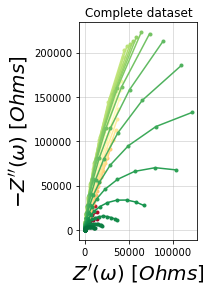

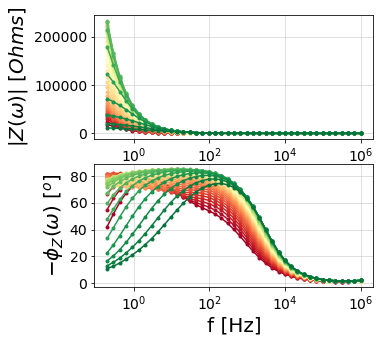

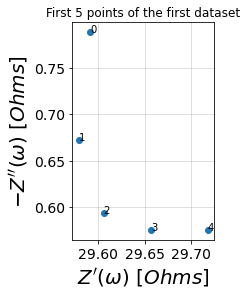

In [4]:
# Get an overview over the whole dataset
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist
import speis_plot as sp

fig, ax = plt.subplots()
# SPEIS_plot.plot_SPEIS_nyquist(ax, Z)
sp.plot_speis_nyquist(ax, Z)
plt.title("Complete dataset")
plt.show()

fig, ax = plt.subplots(nrows=2, figsize=(5, 5))
sp.plot_speis_bode(ax, frequencies, Z)
plt.show()

# First number of points to show
freq_start = 1E+5
freq_end = 1E+1
cutoff_start = np.where(frequencies[0] > freq_start)[0][-1]
cutoff_end = np.where(frequencies[0] < freq_end)[0][0]

# Plot subrange
fig, ax = plt.subplots()
plot_nyquist(ax, Z[0][:cutoff_start], fmt='o')
for i in range(cutoff_start):
    ax.annotate(i, (Z[0][i].real, -Z[0][i].imag))
plt.title("First " + str(cutoff_start) + " points of the first dataset")
plt.show()

In [5]:
#Initialize all implemented circuit models

from impedance.models.circuits import CustomCircuit

#Load Circuit with one parallel RC element
oneRC_string = 'R0-p(R1,C1)'
initial_guess_oneRC = [30, 100, 1E-5]
bounds_oneRC = [[20, 1E+2, 1E-9], [50, 1E+5, 1E-2]]

oneRC = CustomCircuit(oneRC_string, initial_guess=initial_guess_oneRC)

#Load Circuit with one parallel RCPE element
oneRCPE_string = 'R0-p(R1,CPE1)'
parameters1rcpe = ["R_0", "R_1", "CPE_1-T", "CPE_1-P"]
initial_guess_oneRCPE = [30, 1E+3, 1E-5, 1]
bounds_oneRCPE = [[20, 1E+2, 1E-9, 0.8], [50, 1E+7, 1E-2, 1]]

oneRCPE = CustomCircuit(oneRCPE_string, initial_guess=initial_guess_oneRCPE)

#Load Circuit with two parallel RCPE elements
twoRCPE_string = 'R0-p(R1,CPE1)-p(R2,CPE2)'
parameters2rcpe = ["R_0", "R_1", "CPE_1-T", "CPE_1-P", "R_2", "CPE_2-T", "CPE_2-P"]
initial_guess_twoRCPE = [30, 1E+3, 1E-5, 1, 1E+2, 1E-6, 1]
bounds_twoRCPE = [[20, 1E+2, 1E-9, 0.4, 1E+2, 1E-9, 0.8], [50, 1E+5, 1E-2, 1, 1E+6, 1E-2, 1]]

twoRCPE = CustomCircuit(twoRCPE_string, initial_guess=initial_guess_twoRCPE)

## Selection of cycles to analyze

In [6]:
from impedance.visualization import plot_altair
import altair as alt

dicts = {}
for step in range(0,potstepnumber):
    dicts[str(step*pot_step+pot_start) + "mV"] = {'f': frequencies[step], 'Z': Z[step]}
plot_altair(dicts)

alt.HConcatChart(...)

In [7]:
print("There are " + str(potstepnumber) + " cycles in total.")
print("With which cycle number do you want to start your analysis?")
cycle_start = int(input())-1
print("With which cycle number do you want to end your analysis?")
cycle_end = int(input())-1

There are 41 cycles in total.
With which cycle number do you want to start your analysis?
6
With which cycle number do you want to end your analysis?
41


## Selection of fitting model

In [8]:
print("Which model do you want to use? (1RC, 1RCPE or 2RCPE)")
model = input()

if model == "1RC":
    results = [initial_guess_oneRC]
    model_circuit_bounds = bounds_oneRC
    model_circuit = oneRC
elif model == "1RCPE":
    results = [initial_guess_oneRCPE]
    model_circuit = oneRCPE
    model_circuit_bounds = bounds_oneRCPE
elif model == "2RCPE":
    results = [initial_guess_twoRCPE]
    model_circuit = twoRCPE
    model_circuit_bounds = bounds_twoRCPE
else:
    print("Eingabe ungültig")

Which model do you want to use? (1RC, 1RCPE or 2RCPE)
1RCPE


<IPython.core.display.Javascript object>

Result of Cycle 5:


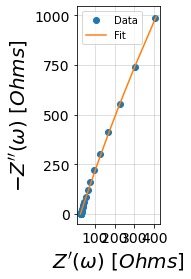

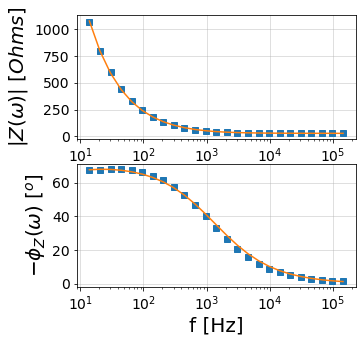


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.81e+01  (+/- 7.65e-01) [Ohm]
     R1 = 1.95e+04  (+/- 2.29e+03) [Ohm]
  CPE1_0 = 2.58e-05  (+/- 4.44e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01  (+/- 3.22e-03) []

Fitting error of parameter #1 at 11.7%


Result of Cycle 6:


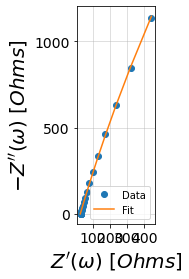

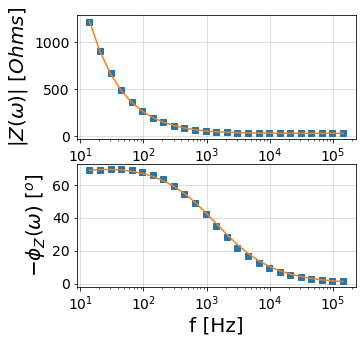


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.83e+01  (+/- 6.66e-01) [Ohm]
     R1 = 1.92e+04  (+/- 1.50e+03) [Ohm]
  CPE1_0 = 2.08e-05  (+/- 2.74e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.19e-01  (+/- 2.49e-03) []



Result of Cycle 7:


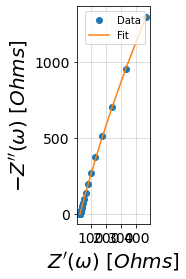

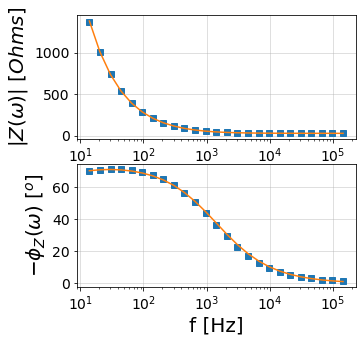


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.89e+01  (+/- 5.43e-01) [Ohm]
     R1 = 1.99e+04  (+/- 1.03e+03) [Ohm]
  CPE1_0 = 1.70e-05  (+/- 1.62e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.37e-01  (+/- 1.82e-03) []



Result of Cycle 8:


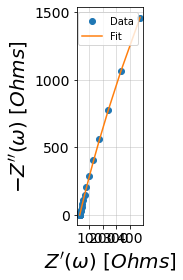

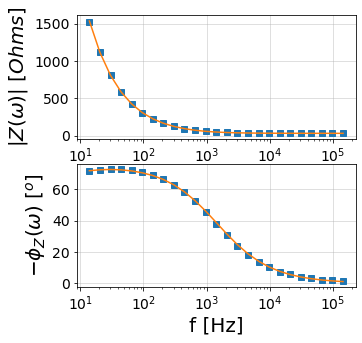


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.94e+01  (+/- 4.14e-01) [Ohm]
     R1 = 2.32e+04  (+/- 8.58e+02) [Ohm]
  CPE1_0 = 1.43e-05  (+/- 9.35e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.52e-01  (+/- 1.26e-03) []



Result of Cycle 9:


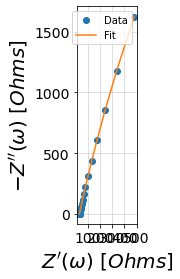

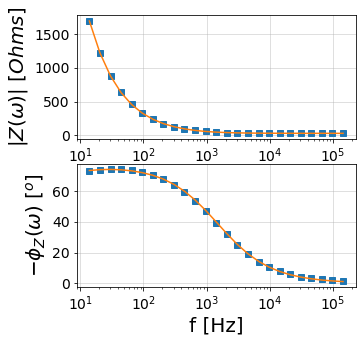


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.98e+01  (+/- 3.20e-01) [Ohm]
     R1 = 2.83e+04  (+/- 8.14e+02) [Ohm]
  CPE1_0 = 1.22e-05  (+/- 5.63e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.65e-01  (+/- 8.89e-04) []



Result of Cycle 10:


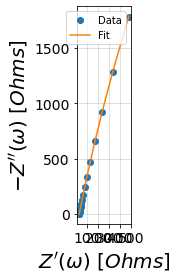

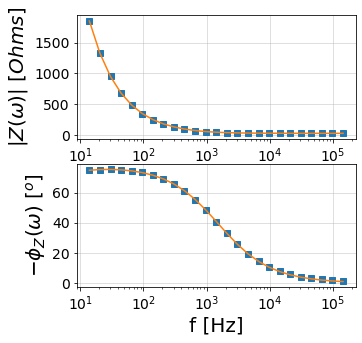


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.02e+01  (+/- 2.32e-01) [Ohm]
     R1 = 3.57e+04  (+/- 7.96e+02) [Ohm]
  CPE1_0 = 1.07e-05  (+/- 3.29e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.76e-01  (+/- 5.95e-04) []



Result of Cycle 11:


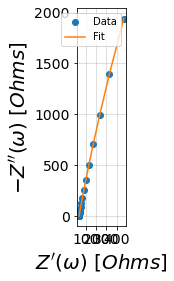

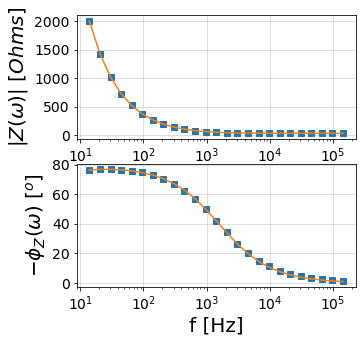


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.04e+01  (+/- 1.90e-01) [Ohm]
     R1 = 4.67e+04  (+/- 9.54e+02) [Ohm]
  CPE1_0 = 9.53e-06  (+/- 2.21e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.85e-01  (+/- 4.53e-04) []



Result of Cycle 12:


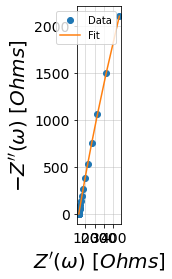

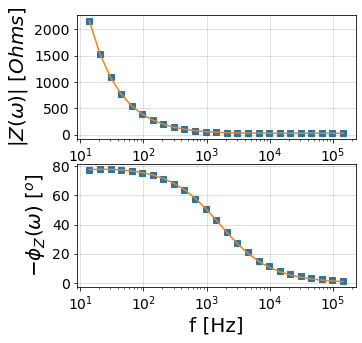


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.07e+01  (+/- 1.48e-01) [Ohm]
     R1 = 6.20e+04  (+/- 1.13e+03) [Ohm]
  CPE1_0 = 8.54e-06  (+/- 1.43e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.93e-01  (+/- 3.28e-04) []



Result of Cycle 13:


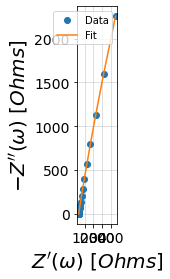

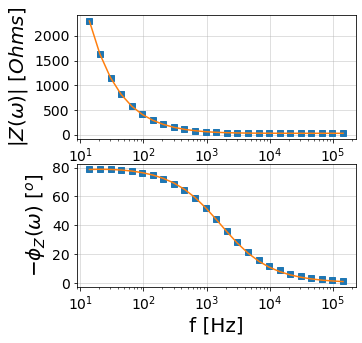


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.09e+01  (+/- 1.41e-01) [Ohm]
     R1 = 8.29e+04  (+/- 1.69e+03) [Ohm]
  CPE1_0 = 7.77e-06  (+/- 1.16e-08) [Ohm^-1 sec^a]
  CPE1_1 = 9.00e-01  (+/- 2.94e-04) []



Result of Cycle 14:


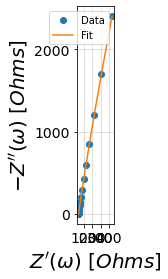

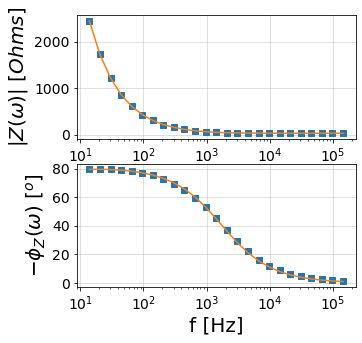


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.10e+01  (+/- 1.54e-01) [Ohm]
     R1 = 1.17e+05  (+/- 3.27e+03) [Ohm]
  CPE1_0 = 7.13e-06  (+/- 1.10e-08) [Ohm^-1 sec^a]
  CPE1_1 = 9.06e-01  (+/- 3.03e-04) []



Result of Cycle 15:


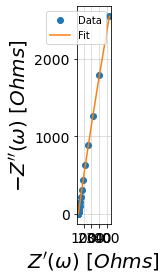

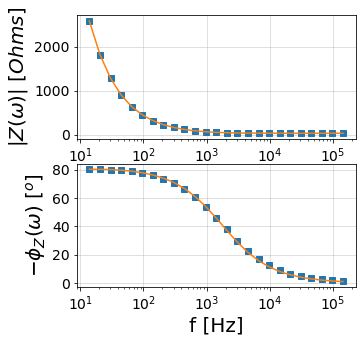


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.12e+01  (+/- 1.68e-01) [Ohm]
     R1 = 1.51e+05  (+/- 5.30e+03) [Ohm]
  CPE1_0 = 6.57e-06  (+/- 1.04e-08) [Ohm^-1 sec^a]
  CPE1_1 = 9.12e-01  (+/- 3.14e-04) []



Result of Cycle 16:


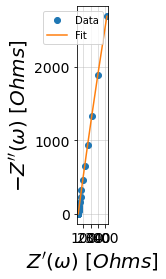

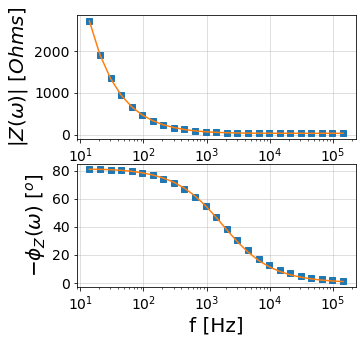


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.13e+01  (+/- 1.83e-01) [Ohm]
     R1 = 2.10e+05  (+/- 1.01e+04) [Ohm]
  CPE1_0 = 6.11e-06  (+/- 1.00e-08) [Ohm^-1 sec^a]
  CPE1_1 = 9.17e-01  (+/- 3.25e-04) []



Result of Cycle 17:


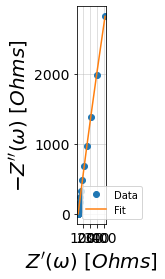

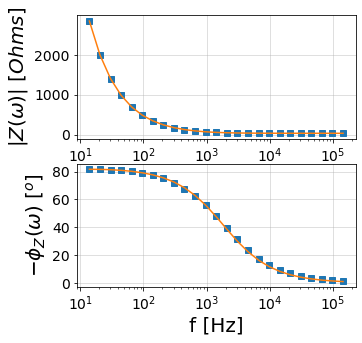


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.15e+01  (+/- 1.94e-01) [Ohm]
     R1 = 2.48e+05  (+/- 1.36e+04) [Ohm]
  CPE1_0 = 5.71e-06  (+/- 9.46e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.21e-01  (+/- 3.29e-04) []



Result of Cycle 18:


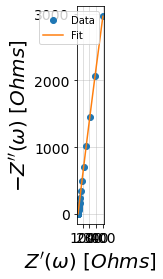

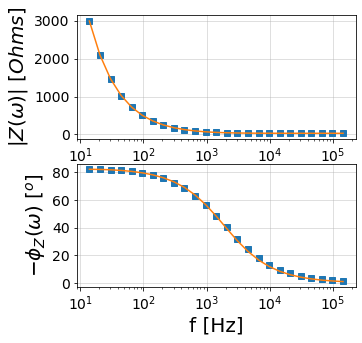


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.16e+01  (+/- 2.12e-01) [Ohm]
     R1 = 3.56e+05  (+/- 2.80e+04) [Ohm]
  CPE1_0 = 5.35e-06  (+/- 9.26e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.26e-01  (+/- 3.44e-04) []



Result of Cycle 19:


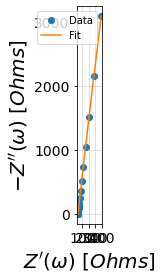

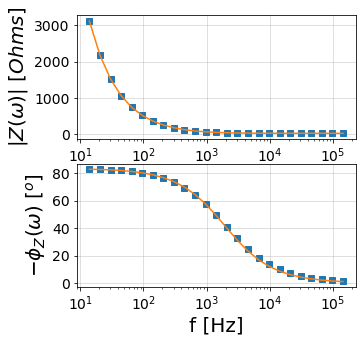


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.17e+01  (+/- 2.24e-01) [Ohm]
     R1 = 5.18e+05  (+/- 5.76e+04) [Ohm]
  CPE1_0 = 5.04e-06  (+/- 8.85e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.29e-01  (+/- 3.49e-04) []

Fitting error of parameter #1 at 11.1%


Result of Cycle 20:


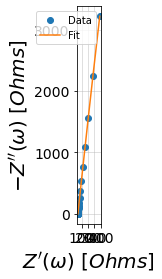

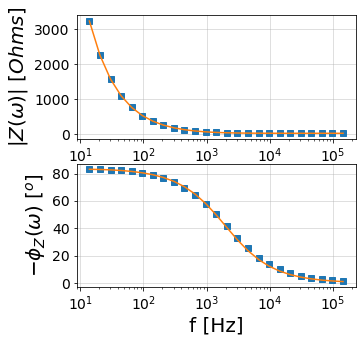


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.18e+01  (+/- 2.37e-01) [Ohm]
     R1 = 6.48e+05  (+/- 8.84e+04) [Ohm]
  CPE1_0 = 4.77e-06  (+/- 8.52e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.33e-01  (+/- 3.56e-04) []

Fitting error of parameter #1 at 13.6%


Result of Cycle 21:


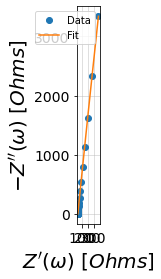

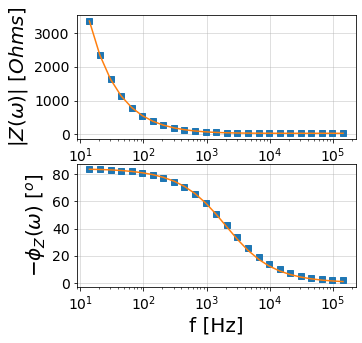


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.18e+01  (+/- 2.44e-01) [Ohm]
     R1 = 8.98e+05  (+/- 7.82e-08) [Ohm]
  CPE1_0 = 4.53e-06  (+/- 3.58e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.36e-01  (+/- 1.57e-04) []



Result of Cycle 22:


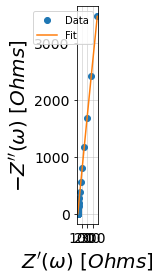

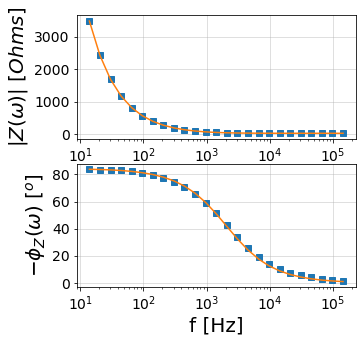


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.19e+01  (+/- 2.52e-01) [Ohm]
     R1 = 1.09e+06  (+/- 5.85e-08) [Ohm]
  CPE1_0 = 4.31e-06  (+/- 3.42e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.39e-01  (+/- 1.57e-04) []



Result of Cycle 23:


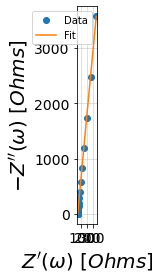

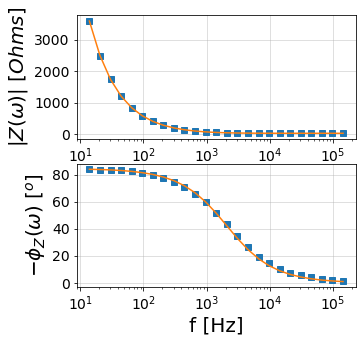


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.20e+01  (+/- 2.59e-01) [Ohm]
     R1 = 1.54e+06  (+/- 3.21e-08) [Ohm]
  CPE1_0 = 4.13e-06  (+/- 3.26e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.42e-01  (+/- 1.56e-04) []



Result of Cycle 24:


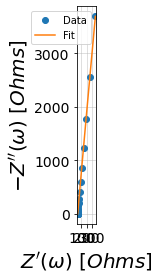

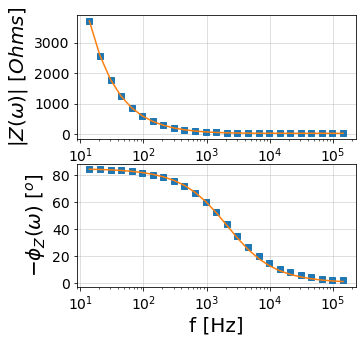


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 2.77e-01) [Ohm]
     R1 = 1.49e+06  (+/- 3.85e-08) [Ohm]
  CPE1_0 = 3.96e-06  (+/- 3.24e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.45e-01  (+/- 1.63e-04) []



Result of Cycle 25:


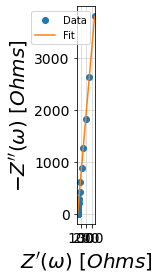

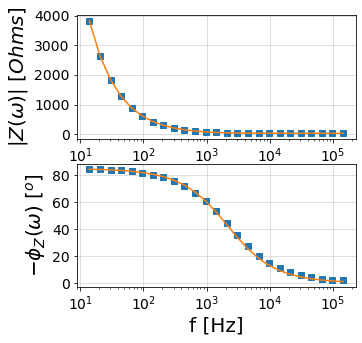


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 2.78e-01) [Ohm]
     R1 = 1.71e+06  (+/- 3.03e-08) [Ohm]
  CPE1_0 = 3.81e-06  (+/- 3.04e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.47e-01  (+/- 1.59e-04) []



Result of Cycle 26:


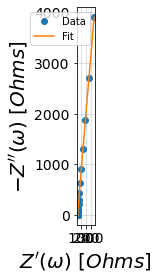

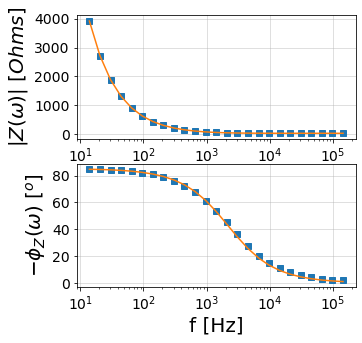


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.22e+01  (+/- 2.84e-01) [Ohm]
     R1 = 1.33e+06  (+/- 5.44e-08) [Ohm]
  CPE1_0 = 3.67e-06  (+/- 2.93e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.49e-01  (+/- 1.58e-04) []



Result of Cycle 27:


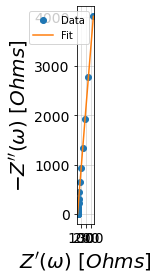

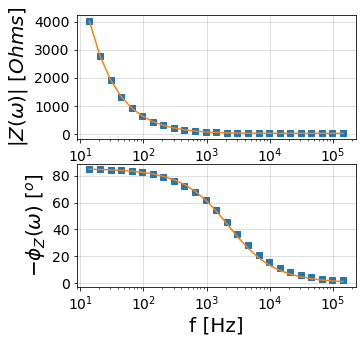


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.22e+01  (+/- 2.88e-01) [Ohm]
     R1 = 1.59e+06  (+/- 4.17e-08) [Ohm]
  CPE1_0 = 3.55e-06  (+/- 2.79e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.51e-01  (+/- 1.56e-04) []



Result of Cycle 28:


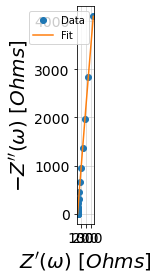

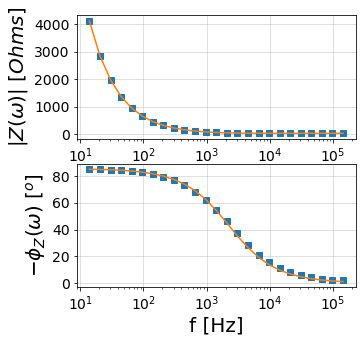


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 2.80e-01) [Ohm]
     R1 = 1.07e+06  (+/- 9.23e-08) [Ohm]
  CPE1_0 = 3.45e-06  (+/- 2.58e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.52e-01  (+/- 1.48e-04) []



Result of Cycle 29:


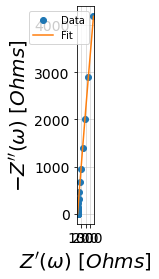

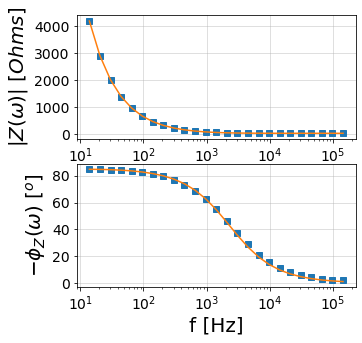


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 2.70e-01) [Ohm]
     R1 = 7.39e+05  (+/- 1.94e-07) [Ohm]
  CPE1_0 = 3.37e-06  (+/- 2.39e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.52e-01  (+/- 1.40e-04) []



Result of Cycle 30:


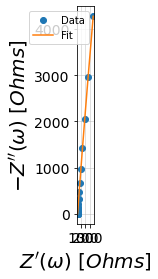

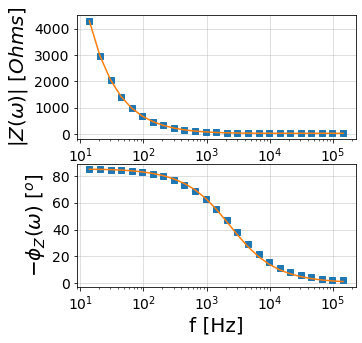


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.22e+01  (+/- 2.77e-01) [Ohm]
     R1 = 6.57e+05  (+/- 2.60e-07) [Ohm]
  CPE1_0 = 3.28e-06  (+/- 2.33e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.54e-01  (+/- 1.41e-04) []



Result of Cycle 31:


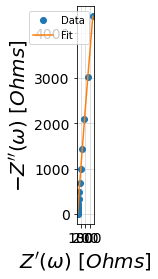

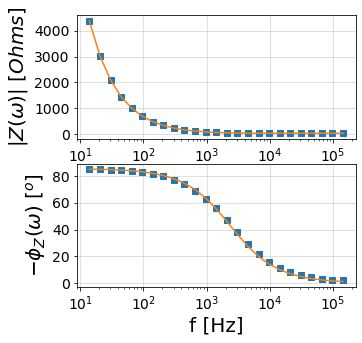


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.22e+01  (+/- 2.88e-01) [Ohm]
     R1 = 6.46e+05  (+/- 5.85e+04) [Ohm]
  CPE1_0 = 3.19e-06  (+/- 5.12e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.55e-01  (+/- 3.22e-04) []



Result of Cycle 32:


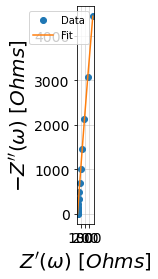

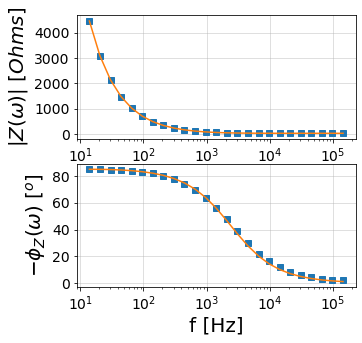


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 2.80e-01) [Ohm]
     R1 = 5.65e+05  (+/- 4.20e+04) [Ohm]
  CPE1_0 = 3.13e-06  (+/- 4.79e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.56e-01  (+/- 3.08e-04) []



Result of Cycle 33:


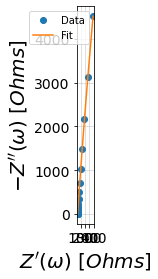

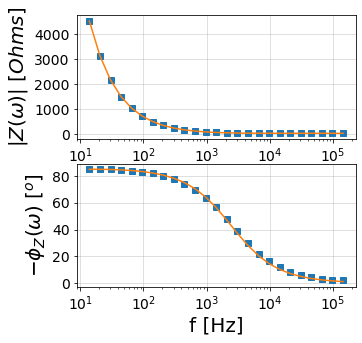


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 2.78e-01) [Ohm]
     R1 = 4.53e+05  (+/- 2.58e+04) [Ohm]
  CPE1_0 = 3.07e-06  (+/- 4.58e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.57e-01  (+/- 3.00e-04) []



Result of Cycle 34:


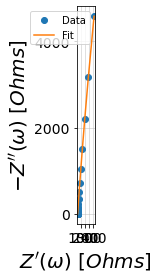

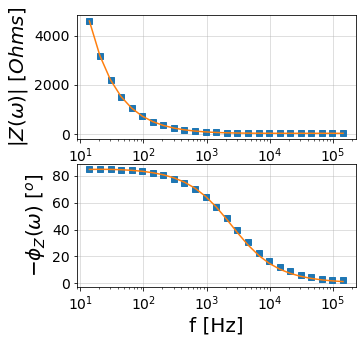


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.21e+01  (+/- 2.69e-01) [Ohm]
     R1 = 3.06e+05  (+/- 1.11e+04) [Ohm]
  CPE1_0 = 3.02e-06  (+/- 4.30e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.57e-01  (+/- 2.86e-04) []



Result of Cycle 35:


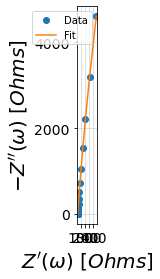

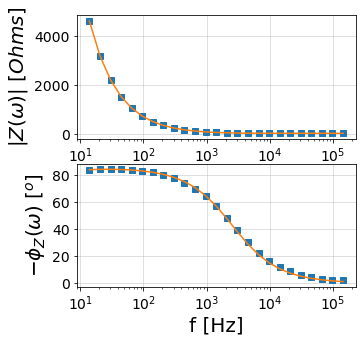


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.19e+01  (+/- 2.57e-01) [Ohm]
     R1 = 1.92e+05  (+/- 4.13e+03) [Ohm]
  CPE1_0 = 3.01e-06  (+/- 4.06e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.56e-01  (+/- 2.71e-04) []



Result of Cycle 36:


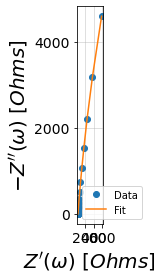

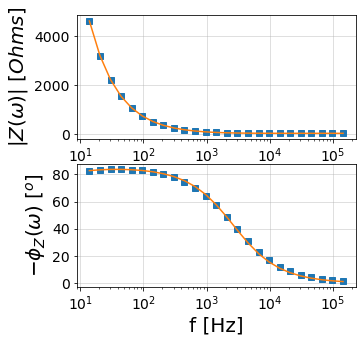


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.14e+01  (+/- 2.85e-01) [Ohm]
     R1 = 1.04e+05  (+/- 1.34e+03) [Ohm]
  CPE1_0 = 3.05e-06  (+/- 4.56e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.52e-01  (+/- 3.01e-04) []



Result of Cycle 37:


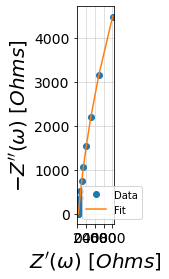

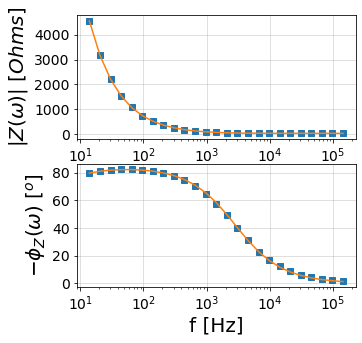


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 3.03e+01  (+/- 5.55e-01) [Ohm]
     R1 = 5.31e+04  (+/- 6.97e+02) [Ohm]
  CPE1_0 = 3.18e-06  (+/- 9.40e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.45e-01  (+/- 5.93e-04) []



Result of Cycle 38:


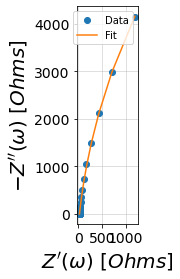

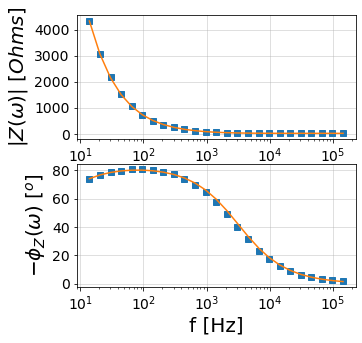


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.84e+01  (+/- 1.14e+00) [Ohm]
     R1 = 2.61e+04  (+/- 3.76e+02) [Ohm]
  CPE1_0 = 3.50e-06  (+/- 2.21e-08) [Ohm^-1 sec^a]
  CPE1_1 = 9.31e-01  (+/- 1.26e-03) []



Result of Cycle 39:


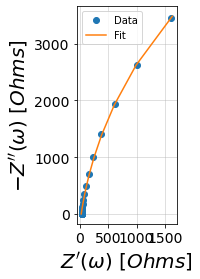

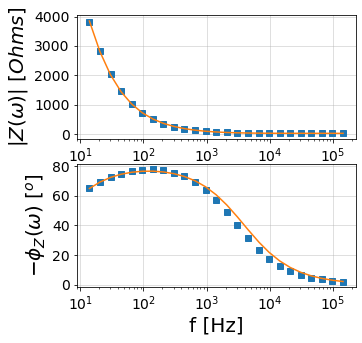


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.54e+01  (+/- 2.01e+00) [Ohm]
     R1 = 1.35e+04  (+/- 2.14e+02) [Ohm]
  CPE1_0 = 4.16e-06  (+/- 5.17e-08) [Ohm^-1 sec^a]
  CPE1_1 = 9.06e-01  (+/- 2.44e-03) []





<IPython.core.display.Javascript object>

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist
import pandas as pd
from IPython.core.debugger import set_trace

%notify -m "The fitting has been started!"
for i in range(cycle_start, cycle_end):
    print("Result of Cycle \033[1m" + str(i) + "\033[0m:")
    Z_i = Z[i][cutoff_start:cutoff_end]
    frequency_i = frequencies[i][cutoff_start:cutoff_end]
    model_circuit.fit(frequency_i, Z_i, bounds=model_circuit_bounds)
    Z_fit = model_circuit.predict(frequency_i)
    fig, ax = plt.subplots()
    plot_nyquist(ax, Z_i, fmt='o')
    plot_nyquist(ax, Z_fit, fmt='-')
    plt.legend(['Data', 'Fit'])
    plt.show()
    model_circuit.plot(f_data=frequency_i, Z_data=Z_i, kind='bode')
    plt.show()
    print(model_circuit)
    errorlist = [0]
    for j in range(len(model_circuit.parameters_)):
        relerror = model_circuit.conf_[j]/model_circuit.parameters_[j]
        errorlist.append(relerror)
        if relerror > 0.1:
            print("Fitting error of parameter #" + str(j) + " at " + str(round(100*relerror, 1)) + "%")
    results.append(model_circuit.parameters_.tolist() + model_circuit.conf_.tolist() + errorlist[1:])
    print("\n")
%notify -m "The fitting has been completed!"

## Wrap data into dataframe and save dataframe as Excel file

In [10]:
names, units = model_circuit.get_param_names()
df = pd.DataFrame(data=results, columns=[names + ["Error of " + x for x in names] + ["Rel. Error of " + x for x in names]])

In [11]:
print(df)

           R0            R1    CPE1_0    CPE1_1 Error of R0   Error of R1  \
0   30.000000  1.000000e+03  0.000010  1.000000         NaN           NaN   
1   28.107496  1.950128e+04  0.000026  0.800000    0.765115  2.287505e+03   
2   28.346819  1.924870e+04  0.000021  0.818554    0.666357  1.495547e+03   
3   28.871709  1.991359e+04  0.000017  0.836771    0.542997  1.029318e+03   
4   29.366011  2.315310e+04  0.000014  0.852129    0.414307  8.576719e+02   
5   29.801377  2.825035e+04  0.000012  0.864878    0.320073  8.142219e+02   
6   30.161890  3.569566e+04  0.000011  0.875656    0.232177  7.957783e+02   
7   30.436414  4.666416e+04  0.000010  0.884694    0.190401  9.537217e+02   
8   30.725571  6.195801e+04  0.000009  0.893075    0.147730  1.128432e+03   
9   30.910728  8.293844e+04  0.000008  0.899870    0.140756  1.692317e+03   
10  31.035989  1.171060e+05  0.000007  0.905867    0.153880  3.273175e+03   
11  31.185414  1.505824e+05  0.000007  0.911605    0.168103  5.297158e+03   

In [12]:
#Add voltage steps to the dataframe as first two columns
df.insert(loc = 0, column = "V vs. Ag/AgCl (mV)", value = ["(initial guess)"] + potentials_Ag[cycle_start:cycle_end])
df.insert(loc = 1, column = "V vs. RHE (mV)", value = ["(initial guess)"] + [x+197+59*pot_pH for x in potentials_Ag][cycle_start:cycle_end])

Optional: Calculate real capacitance based on CPE and R values using  C = ( CPE-T * R )(1/CPE-P) / R

In [13]:
if model == "1RCPE":
    df.insert(loc = len(df.columns), column = "C_1 (calculated)", value = [pow((df.loc[i]["CPE1_0"]*df.loc[i]["R1"]), 1/df.loc[i]["CPE1_1"])/df.loc[i]["R1"] for i in range(df.shape[0])])

In [14]:
# Create file directory for the analysis
import os
if not os.path.exists(filename):
    os.makedirs(filename)

In [15]:
# Output to excel
savefile = model + "-Analysis-wBounds_" + str(int(df.loc[1, "V vs. Ag/AgCl (mV)"].values)) + " - " + str(int(df.loc[1, "V vs. Ag/AgCl (mV)"].values)) + "mV of " + filename
df.to_excel("./" + filename + "//" + savefile + ".xlsx")

In [16]:
# Save notebook output as HTML
os.system('jupyter nbconvert --to html --output "./' + filename + '//' + savefile + '" "SPEIS automated analysis.ipynb"')

0

## Post-analysis and embedded data treatment

<IPython.core.display.Javascript object>


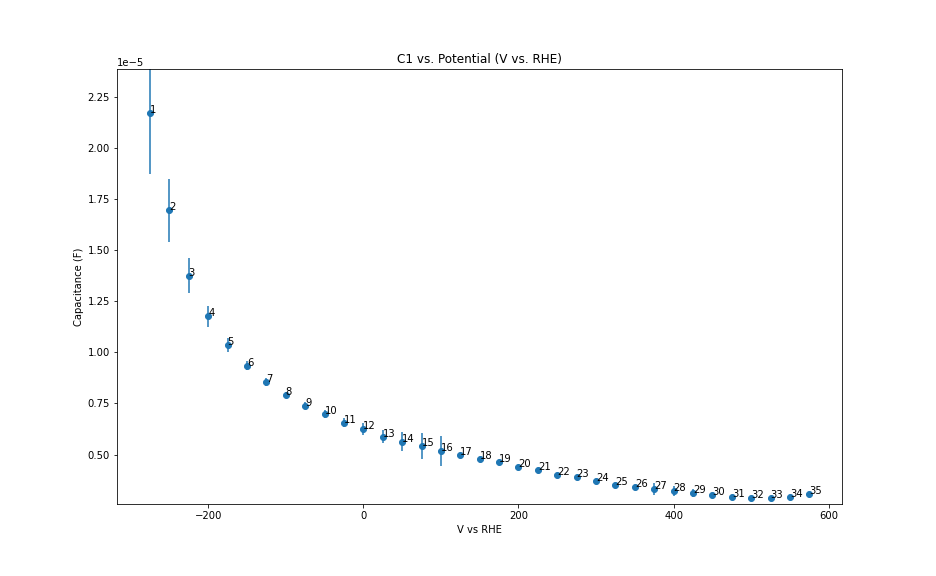

In [20]:
%matplotlib notebook
import mplcursors
# Create plot for calculated capacitance
fig, ax = plt.subplots()

labels = ["a", "b", "c", "d", "e"]
x = df[1:]["V vs. Ag/AgCl (mV)"].values
y = df[1:]["C_1 (calculated)"].values
sum_error = df[1:]["Rel. Error of CPE1_0"].values.flatten() + df[1:]["Rel. Error of R1"].values.flatten() + df[1:]["Rel. Error of CPE1_1"].values.flatten() / 3
y_error = np.multiply(df[1:]["C_1 (calculated)"].values.flatten(), sum_error)

plt.scatter(x, y)
ax.errorbar(x, y, yerr = y_error, linestyle="None")
plt.ylabel("Capacitance (F)")
plt.xlabel("V vs RHE")
plt.ylim(min(y)*0.9, max(y)*1.1)
fig.set_size_inches(13,8)
plt.title("C1 vs. Potential (V vs. RHE)")
for i in range(df.index[0], df.index[-1]):
    ax.annotate(i+1, (x[i], y[i]))
plt.ion()
plt.show()

1
Which cycle do you want to fit again?


<IPython.core.display.Javascript object>


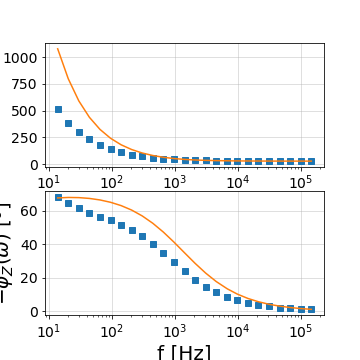


Circuit string: R0-p(R1,CPE1)
Fit: True

Initial guesses:
     R0 = 3.00e+01 [Ohm]
     R1 = 1.00e+03 [Ohm]
  CPE1_0 = 1.00e-05 [Ohm^-1 sec^a]
  CPE1_1 = 1.00e+00 []

Fit parameters:
     R0 = 2.81e+01  (+/- 7.65e-01) [Ohm]
     R1 = 1.95e+04  (+/- 2.29e+03) [Ohm]
  CPE1_0 = 2.58e-05  (+/- 4.44e-07) [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01  (+/- 3.22e-03) []



In [19]:
print("Which cycle do you want to fit again?")
inspec_cycle_no = int(input())

model_circuit = CustomCircuit(model_circuit.circuit, initial_guess=model_circuit.initial_guess)
model_circuit.parameters_ = df.iloc[inspec_cycle_no][2:2+len(model_circuit.initial_guess)].values
model_circuit.conf_ = df.iloc[inspec_cycle_no][len(model_circuit.initial_guess)+2:2+2*len(model_circuit.initial_guess)].values
model_circuit.plot(f_data=frequencies[inspec_cycle_no-1][cutoff_start:cutoff_end], Z_data=Z[inspec_cycle_no-1][cutoff_start:cutoff_end], kind="bode")

print(model_circuit)